In [3]:
!pip install torch diffusers transformers compel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 kB 3.8 MB/s eta 0:00:007.1 MB/s eta 0:00:01


In [1]:
import torch
from compel import Compel
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from torch import Generator

device = "mps"
pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
# dpm++
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config,
                                                             algorithm_type="dpmsolver++")

compel = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/Users/damian/miniforge3/envs/compel/lib/python3.7/site-packages/transformers/models/clip/feature_extraction_clip.py:31: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  FutureWarning,


  0%|          | 0/7 [00:00<?, ?it/s]

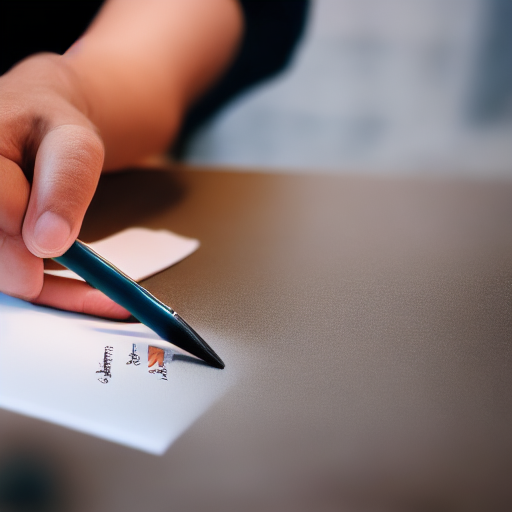

In [32]:
prompt = "a person sitting on a table holding a pen in their hand"
seed = 123

embeds = compel.build_conditioning_tensor(prompt)
fixed_seed_generator = Generator(device="cpu" if compel.device.type == "mps" else compel.device).manual_seed(seed)
image = pipeline(prompt_embeds=embeds, 
#image = pipeline(prompt=prompt,
                 num_inference_steps=7, 
                 generator=fixed_seed_generator).images[0]
display(image)

In [33]:
compel.describe_tokenization(prompt)

['a</w>',
 'person</w>',
 'sitting</w>',
 'on</w>',
 'a</w>',
 'table</w>',
 'holding</w>',
 'a</w>',
 'pen</w>',
 'in</w>',
 'their</w>',
 'hand</w>']

In [6]:
from torch import BoolTensor, FloatTensor
import torch

def mask_to_bias(mask: BoolTensor, dtype: torch.dtype) -> FloatTensor:
    bias: FloatTensor = (1 - mask.to(dtype=dtype)) * -10000.0
    return bias

In [36]:
prompt_length = 12
mask = torch.tensor([
  [True]*77, # stable-diffusion was trained with an unmasked uncond, so sadly it learned to rely on those PAD embeds
  [True] + [True]*prompt_length + [True] + [False]*(77-prompt_length-2), # mask out everything after <eos>
])
bias = mask_to_bias(mask, dtype=torch.float32).to("mps")
print(bias.shape)

fixed_seed_generator = Generator(device="cpu" if compel.device.type == "mps" else compel.device).manual_seed(seed)
image = pipeline(prompt_embeds=embeds, 
                 cross_attention_kwargs={'encoder_attention_bias': bias},
                 num_inference_steps=7, 
                 generator=fixed_seed_generator).images[0]

torch.Size([2, 77])


  0%|          | 0/7 [00:00<?, ?it/s]

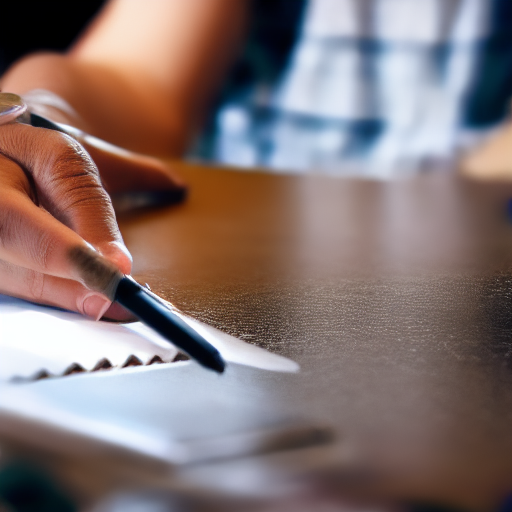

In [37]:
display(image)

  0%|          | 0/15 [00:00<?, ?it/s]

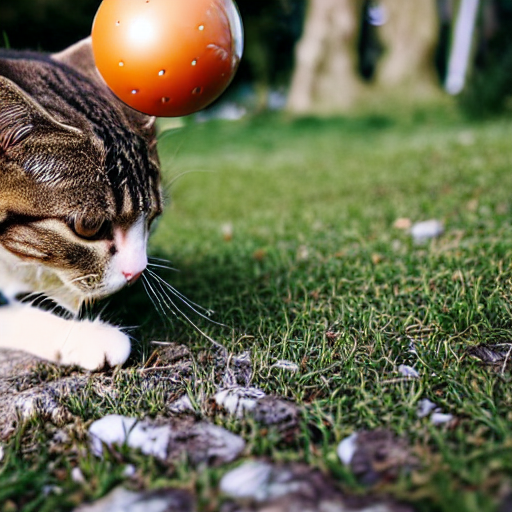

In [24]:
prompt = "a cat playing with a ball (in the forest)-----"
seed = 123

embeds = compel.build_conditioning_tensor(prompt)
fixed_seed_generator = Generator(device="cpu" if compel.device.type == "mps" else compel.device).manual_seed(seed)
image = pipeline(prompt_embeds=embeds, 
                 num_inference_steps=15, 
                 generator=fixed_seed_generator).images[0]
display(image)

  0%|          | 0/15 [00:00<?, ?it/s]

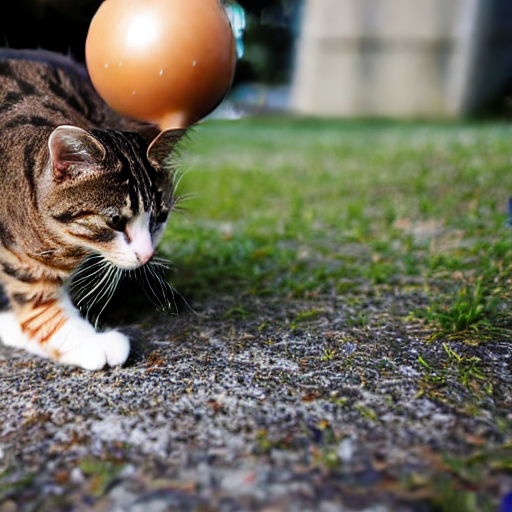

In [26]:
prompt = "a cat playing with a ball (in the forest)-----"
seed = 123

embeds = compel.build_conditioning_tensor(prompt)
fixed_seed_generator = Generator(device="cpu" if compel.device.type == "mps" else compel.device).manual_seed(seed)
image = pipeline(prompt_embeds=embeds, 
                 num_inference_steps=15, 
                 cross_attention_kwargs={'encoder_attention_bias': bias},
                 generator=fixed_seed_generator).images[0]
display(image)